In [16]:
from typing import Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt

In [17]:
F = Callable[[float, float], float]  # Функция двух переменных F(x, y)|
Array = np.ndarray[np.float32]

In [41]:
def Euler(f: F, x0: float, y0: float, n: int = 1000, dx: float = 1e-2) -> Array:
    """
    Метод Эйлера.
    Порядок точности O(dx)
    """
    points = [(x0, y0)]
    x, y = x0, y0
    for _ in range(n):
        y += dx * f(x, y)
        x += dx
        points.append((x, y))
    return np.array(points)

In [43]:
def RungeKuttas2(f: F, x0: float, y0: float, n: int = 1000, dx: float = 1e-2) -> Array:
    """
    Метод Рунге-Кутты 2го порядка точности(метод Эйлера с пересчетом).
    Порядок точности O(dx^2)
    """
    points = [(x0, y0)]
    x, y = x0, y0
    for _ in range(n):
        y_hat = y + dx * f(x, y)
        y += dx * (f(x, y) + f(x + dx, y_hat))/2
        x += dx
        points.append((x, y))
    return np.array(points)

In [44]:
def RungeKuttas4(f: F, x0: float, y0: float, n: int = 1000, dx: float = 1e-2) -> Array:
    """
    Метод Рунге-Кутты 4го порядка точности.
    Порядок точности: O(dx^4)
    """
    points = [(x0, y0)]
    x, y = x0, y0
    for _ in range(n):
        k1 = f(x, y)
        k2 = f(x + dx/2, y + k1*dx/2)
        k3 = f(x + dx/2, y + k2*dx/2)
        k4 = f(x + dx, y + k3*dx)
        y += dx * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        x += dx
        points.append((x, y))
    return np.array(points)

In [71]:
def AdamsBashfort(f: F, x0: float, y0: float, n: int = 1000, dx: float = 1e-2) -> Array:
    """
    Метод Адамса-Башфорта.
    Порядок точности: O(dx)
    """
    points = [(x0, y0), (x0 + dx, y0 + dx*f(x0, y0))]  # Метод Эйлера
    x, y = points[-1]
    for _ in range(2, n):
        y += (3 * points[-1][1] - points[-2][1]) * dx / 2 
        x += dx
        points.append((x, y))
    return np.array(points)

In [72]:
def AdamsMultons(f: F, x0: float, y0: float, coef: list[float], n: int = 1000, dx: float = 1e-2) -> Array:
    """
    Метод Адамса-Мультона.
    Порядок точности: O(dx^k), гдe k = len(coef)
    """
    k = len(coef)
    points = [(x0, y0)]
    x, y = x0, y0
    # Первые шаги считаем через RK4
    for _ in range(k):
        k1 = f(x, y)
        k2 = f(x + dx/2, y + k1*dx/2)
        k3 = f(x + dx/2, y + k2*dx/2)
        k4 = f(x + dx, y + k3*dx)
        y += dx * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        x += dx
        points.append((x, y))

    for _ in range(k, n):
        y_hat = coef[0] * f(x, y)
        for i in range(1, k):
            y_hat += coef[i] * points[-i][1]
        y += y_hat * dx
        x += dx
        points.append((x, y))
    return np.array(points)

# Параметры решения

**$f$ - исходная функция**  
$y'=f(x,y)$


In [46]:
def f(x: float, y: float):
    return y * np.sin(x) ** 2

In [74]:
dx = 1e-2
x0, y0 = 0, 0.1
x1 = 10
n = abs(int((x1 - x0) / dx))


## Построение графика

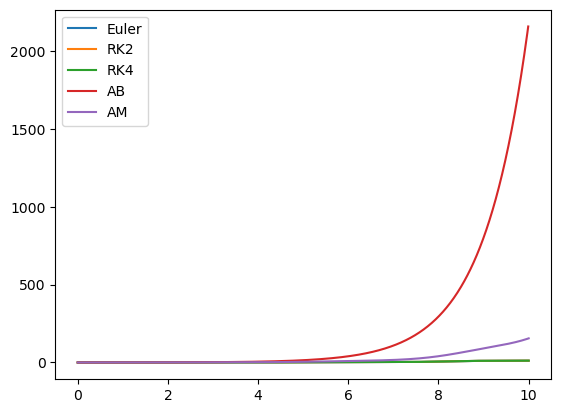

In [75]:
T = Euler(f, x0, y0, n, dx)
plt.plot(T[:, 0], T[:, 1], label="Euler")

T = RungeKuttas2(f, x0, y0, n, dx)
plt.plot(T[:, 0], T[:, 1], label="RK2")

T = RungeKuttas4(f, x0, y0, n, dx)
plt.plot(T[:, 0], T[:, 1], label="RK4")

T = AdamsBashfort(f, x0, y0, n, dx)
plt.plot(T[:, 0], T[:, 1], label="AB")

T = AdamsMultons(f, x0, y0, [1/2, 1/2], n, dx)
plt.plot(T[:, 0], T[:, 1], label="AM")

plt.legend()
plt.show()
